<a href="https://www.kaggle.com/code/serdargundogdu/gdz-enerji-smoothing-ve-statistiksel-z-mler?scriptVersionId=126643576" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# İş Problemi

İzmir ve Manisa illerinde günlük yaşamın vazgeçilmezi olan elektrik enerjisini, insan odaklı hizmet anlayışı ve modern teknoloji sistemleri ile tüketicilerine ulaştıran Gdz Elektrik, geleneksel hale getirdiği Datathon serisinin ikincisinin çözümüdür.

Katılımcıların sunulan veri seti ile Gdz Elektrik sorumluluğundaki şebeke merkezlerine yönelik "enerji dağıtım" tahminleme yaklaşımı geliştirilmesi bekleniyor. 🎯

Kaggle yarışmasında başarı metriği MAPE (Mean Absolute Percentage Error) olacaktır.

# Veri Seti Hikayesi ve Değişkenler

Dosya

● med.csv - Major Event Day veri seti

● train.csv - Train veri seti

● sample_submission.csv - Örnek submission dosyası

Açıklamalar

Major Event Day (MED.CSV): Gün içindeki elektrik kesinti süresinin kabul edilebilir limiti aştığı gün.
Dolayısıyla kesinti olduysa o gün tahmin edilen enerjinin sapmasının yüksek olmasını bekleriz. Çünkü kesinti nedeniyle dağıtılamamış.

Dağıtılan Enerji: Watt: Aktif(yararlı) gücün birimi.
MWh = MegaWatt saat

Dağıtılan Enerji'nin %85'i İzmir, %15'i ise Manisa için gerçekleştirilmektedir.

Dış Veri Kullanımı
Size faydalı olabileceğini düşündüğünüz her türlü halka açık veriyi kullanabilirsiniz.

# Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import itertools
import seaborn as sns
import lightgbm as lgb
import warnings
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')

# Veri Setinin Keşfi

Gün içindeki elektrik kesinti süresinin kabul edilebilir limiti aştığı günlerin okunması ve df_med Dataframe oluşturarak kaydedilmesi.

In [2]:
df_med = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/med.csv', index_col='Tarih', parse_dates=True)
df_train = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/train.csv' , index_col='Tarih', parse_dates=True)
df_test = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/sample_submission.csv', index_col='Tarih', parse_dates=True)
df_all = pd.concat([df_train, df_test], axis=0)

* df_train veri setinde 1673 günlük 24'er saatlikveri vardır.

     df_train veri seti 2018-01-01 00:00:00 tarihinden 2022-07-31 23:00:00 tarihine kadar veri içermektedir.

* df_test veri setinde 31 günlük 24'er saatlik veri vardır.
    
    df_test veri seti 2022-08-01 00:00:00 tarihinden 2022-08-31 23:00:00 tarihine kadar veri içermektedir. 
    
* df_all veri setinde 1704 günlük 24'er saatlik veri vardır.
    
    df_all veri seti 2018-01-01 00:00:00 tarihinden 2022-08-31 23:00:00 tarihine kadar veri içermektedir. 

    "Dağıtılan Enerji (MWh)" = 0 olanlar df_test 
    
    "Dağıtılan Enerji (MWh)" > 0 olanlar df_train

In [3]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Dağıtılan Enerji (MWh),40152.000,1836.805,426.066,870.183,1499.165,1813.409,2129.408,3633.105


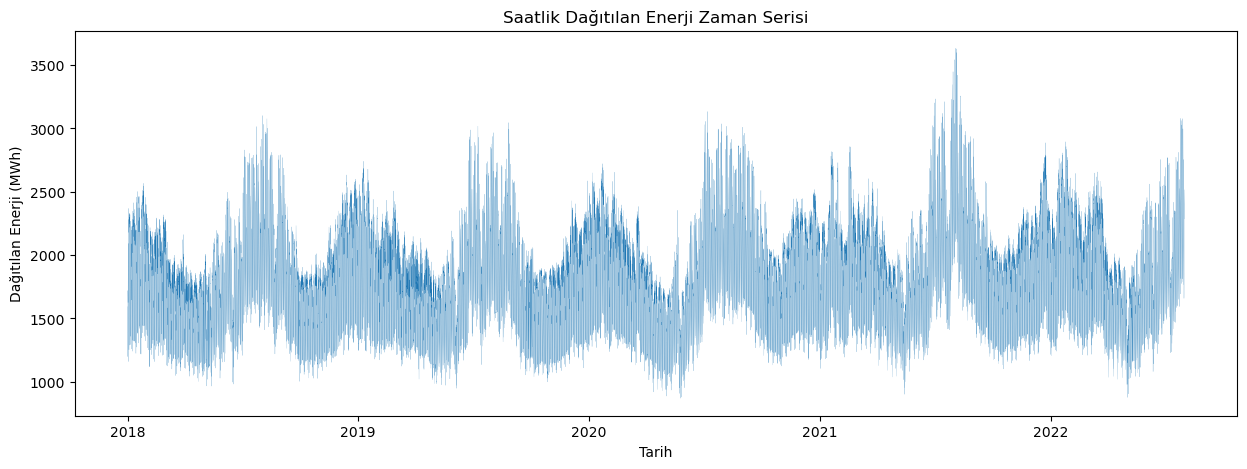

In [4]:
plt.figure(figsize=(15,5))
plt.title("Saatlik Dağıtılan Enerji Zaman Serisi")
plt.plot(df_train["Dağıtılan Enerji (MWh)"],linewidth=0.1)
plt.xlabel("Tarih")
plt.ylabel("Dağıtılan Enerji (MWh)")
plt.show()

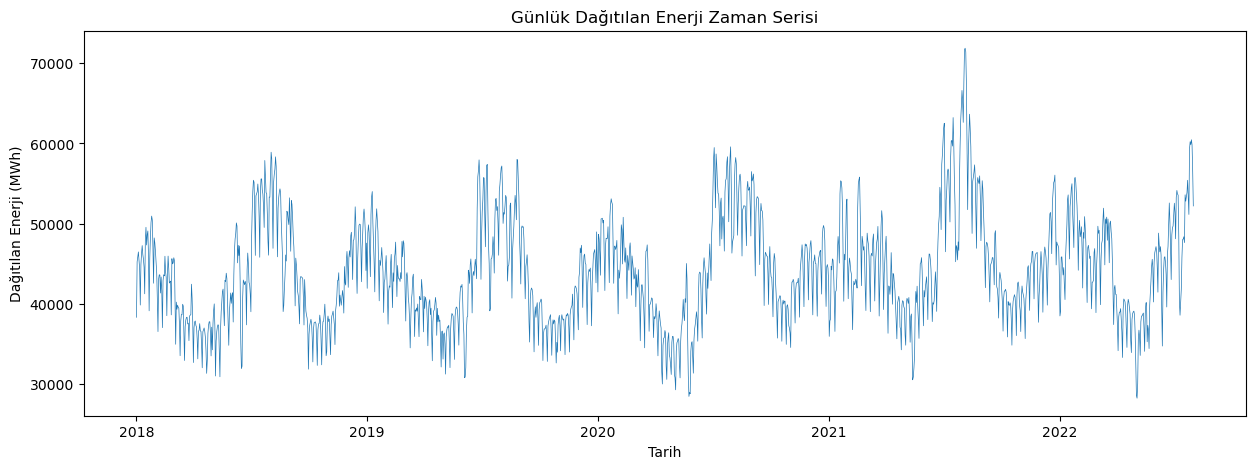

In [5]:
plt.figure(figsize=(15,5))
plt.title("Günlük Dağıtılan Enerji Zaman Serisi")
plt.plot(df_train['Dağıtılan Enerji (MWh)'].resample('D').sum(),linewidth=0.5)
plt.xlabel("Tarih")
plt.ylabel("Dağıtılan Enerji (MWh)")
plt.show()

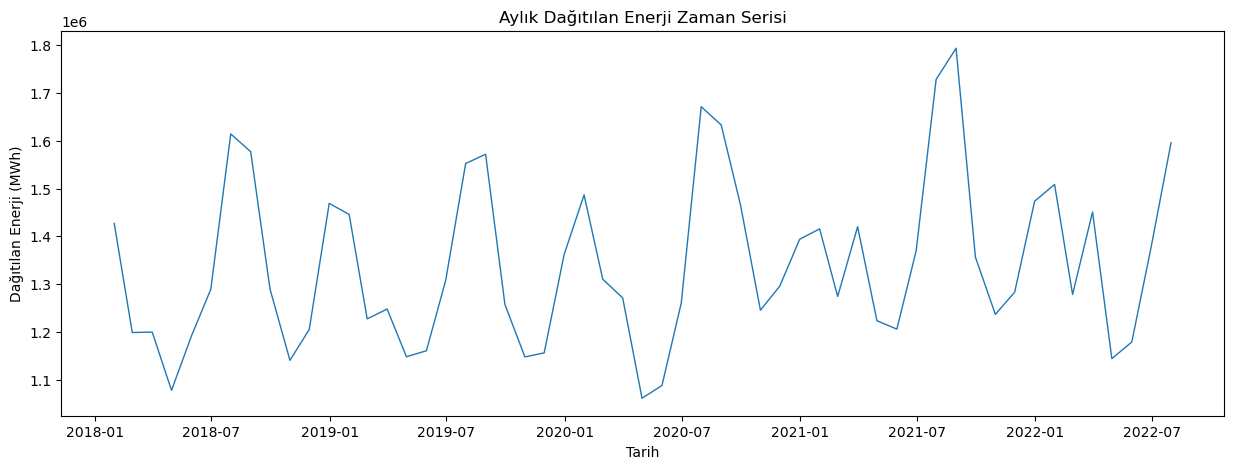

In [6]:
plt.figure(figsize=(15,5))
plt.title("Aylık Dağıtılan Enerji Zaman Serisi")
plt.plot(df_train['Dağıtılan Enerji (MWh)'].resample('M').sum(),linewidth=1)
plt.xlabel("Tarih")
plt.ylabel("Dağıtılan Enerji (MWh)")
plt.show()

# Smoothing Yöntemleri ile Tahmin

Veriler günlük ortalama değerlere çevirilip daha sonra saatlik Ağustos ayı dağılımlarına göre dağıtılacaktır.
2022 Ağustos ayı günleri tahmini için 2021 Ağustos ayı günleri değerleri validasyon verisi olarak alınacaktır.

In [7]:
train = df_train['Dağıtılan Enerji (MWh)'].resample('D').sum()[:"2021.07.31"]
val = df_train['Dağıtılan Enerji (MWh)'].resample('D').sum()["2021.08.01":"2021.08.31"]
df_val = df_train[(df_train.index >="2021.08.01 00:00:00") & (df_train.index <= "2021.08.31 23:00:00")]

In [8]:
# Durağanlık Testi (Dickey-Fuller Testi)

def is_stationary(y):

    # "HO: Non-stationary"
    # "H1: Stationary"

    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        print(F"Result: Stationary (H0: non-stationary, p-value: \
          {round(p_value, 3)})")
    else:
        print(F"Result: Non-Stationary (H0: non-stationary, p-value: \
          {round(p_value, 3)})")

is_stationary(train)

Result: Non-Stationary (H0: non-stationary, p-value:           0.061)


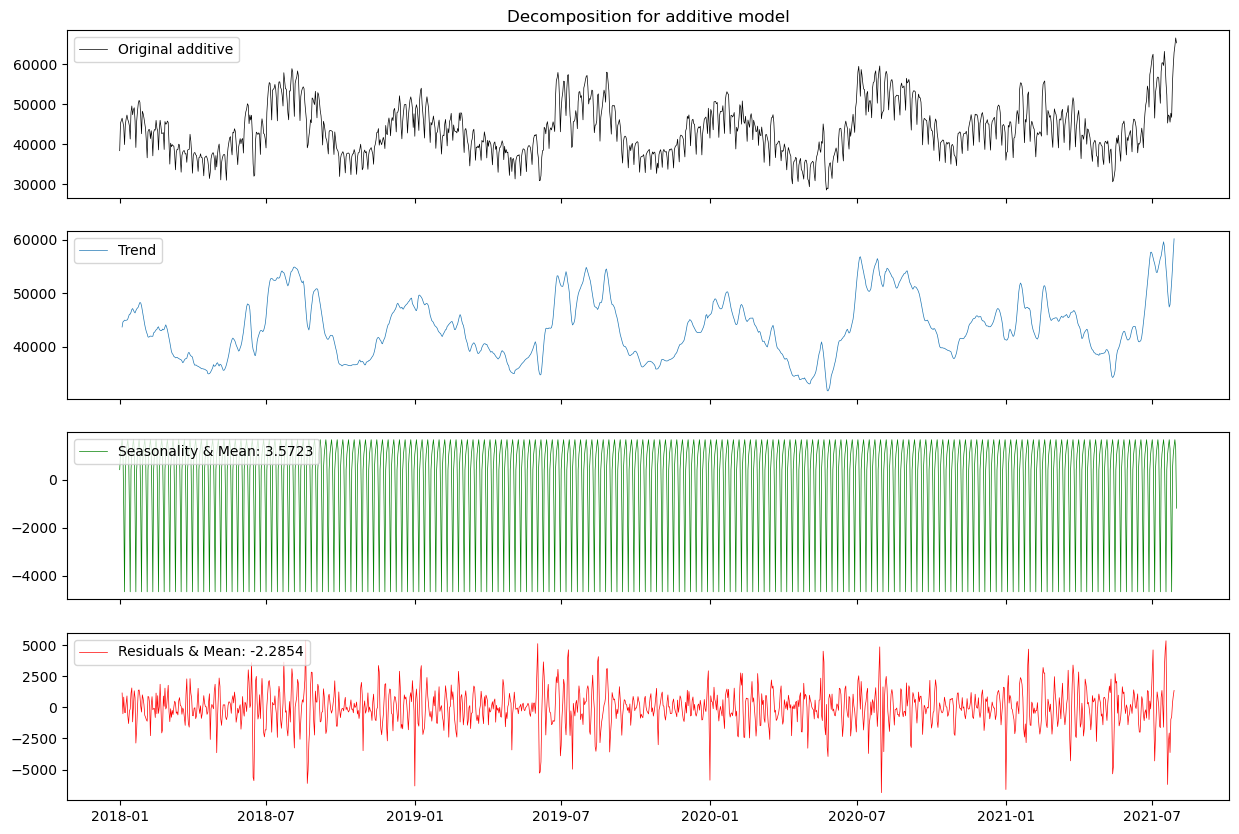

Result: Non-Stationary (H0: non-stationary, p-value:           0.061)


In [9]:
# Zaman Serisi Bileşenleri ve Durağanlık Testi
# multiplicative
def ts_decompose(y, model="additive", stationary=False):
    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', lw = 0.5, label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, lw = 0.5, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', lw = 0.5, label='Seasonality & Mean: ' + 
              str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', lw = 0.5, label='Residuals & Mean: ' + 
              str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

    if stationary:
        is_stationary(y)

ts_decompose(train, stationary=True)

# SES Model

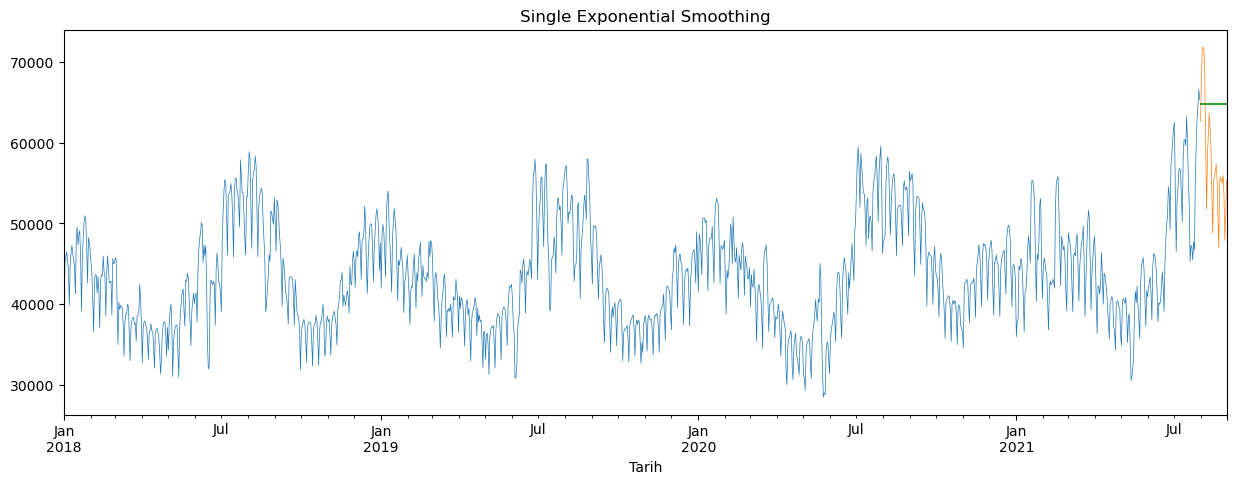

In [10]:
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=0.5)

y_pred = ses_model.forecast(31)

mean_absolute_percentage_error(val, y_pred)

ax = train.plot(figsize=(15,5), title="Single Exponential Smoothing", lw = 0.5)
val.plot(ax=ax, lw =0.5)
y_pred.plot()
plt.show()

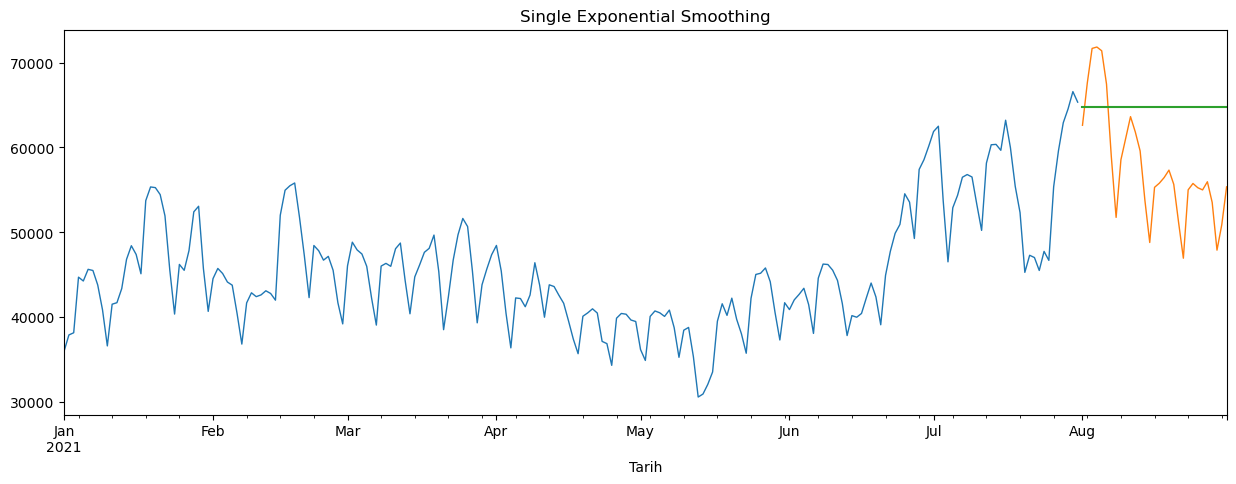

In [11]:
ax = train["2021.01.01":].plot(figsize=(15,5), title="Single Exponential Smoothing", lw = 1)
val.plot(ax=ax, lw =1)
y_pred.plot()
plt.show()

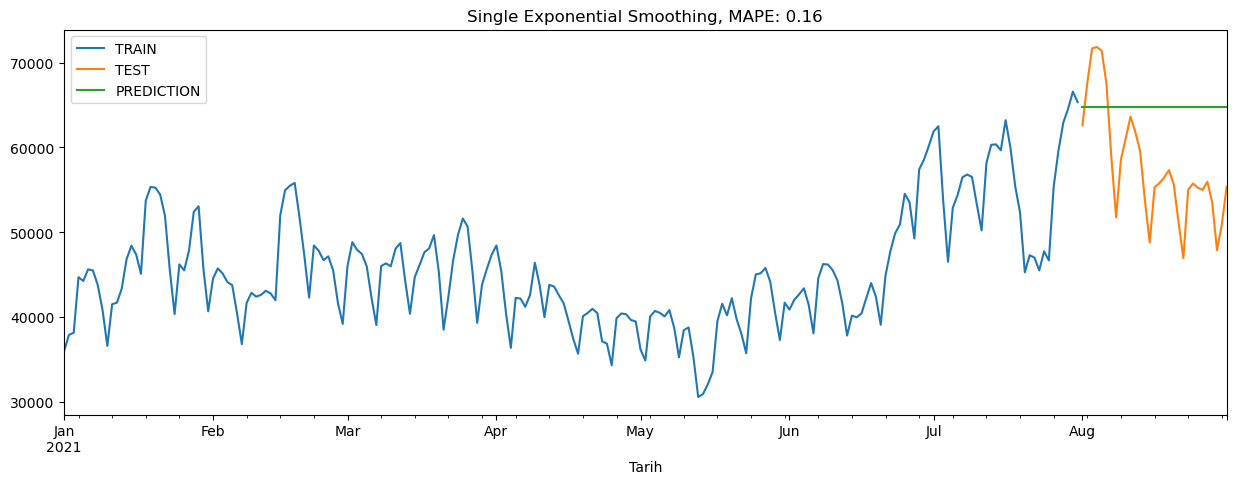

{'smoothing_level': 0.5,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 41906.923567450045,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [12]:
def plot_energy(train, test, y_pred, title):
    mape = mean_absolute_percentage_error(test, y_pred)
    ax = train["2021.01.01":].plot(figsize=(15,5), legend=True, label="TRAIN", title=f"{title}, MAPE: {round(mape,2)}")
    test.plot(ax = ax, legend=True, label="TEST")
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show(block=True)

plot_energy(train, val, y_pred, "Single Exponential Smoothing")

ses_model.params

alpha: 0.8 mape: 0.1667
alpha: 0.81 mape: 0.1667
alpha: 0.82 mape: 0.1667
alpha: 0.83 mape: 0.1666
alpha: 0.84 mape: 0.1666
alpha: 0.85 mape: 0.1665
alpha: 0.86 mape: 0.1665
alpha: 0.87 mape: 0.1664
alpha: 0.88 mape: 0.1663
alpha: 0.89 mape: 0.1662
alpha: 0.9 mape: 0.1661
alpha: 0.91 mape: 0.166
alpha: 0.92 mape: 0.1659
alpha: 0.93 mape: 0.1658
alpha: 0.94 mape: 0.1657
alpha: 0.95 mape: 0.1655
alpha: 0.96 mape: 0.1654
alpha: 0.97 mape: 0.1653
alpha: 0.98 mape: 0.1651
alpha: 0.99 mape: 0.165
best_alpha: 0.99 best_mape: 0.165


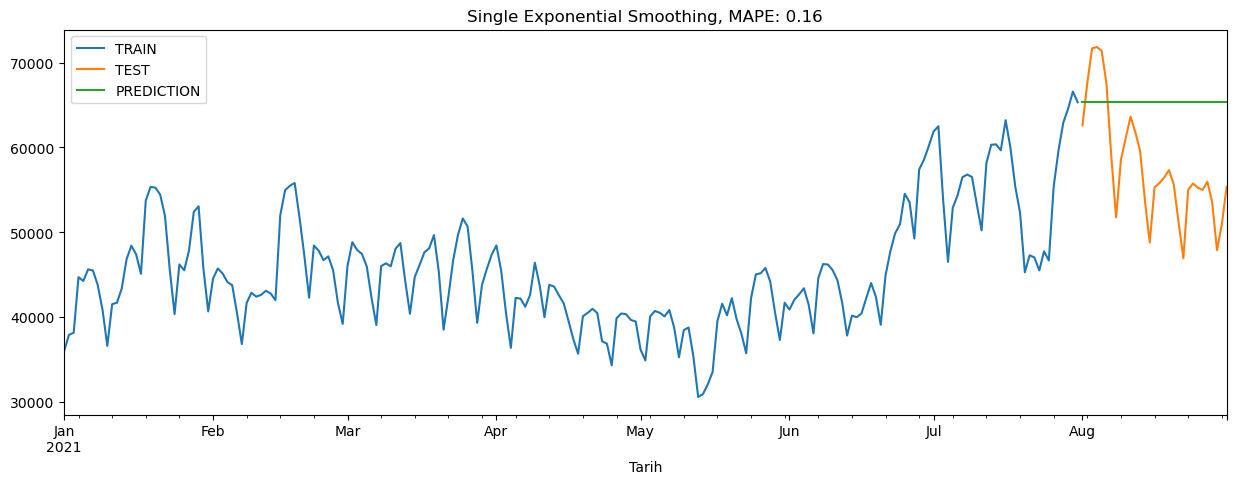

In [13]:
def ses_optimizer(train, alphas, step=31):

    best_alpha, best_mape = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mape = mean_absolute_percentage_error(val, y_pred)

        if mape < best_mape:
            best_alpha, best_mape = alpha, mape

        print("alpha:", round(alpha, 2), "mape:", round(mape, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mape:", round(best_mape, 4))
    return best_alpha, best_mape

alphas = np.arange(0.8, 1, 0.01)

# yt_sapka = a * yt-1 + (1-a)* (yt_-1)_sapka


best_alpha, best_mape = ses_optimizer(train, alphas)

############################
# Final SES Model
############################

ses_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)
y_pred = ses_model.forecast(31)

plot_energy(train, val, y_pred, "Single Exponential Smoothing")

# DES Model

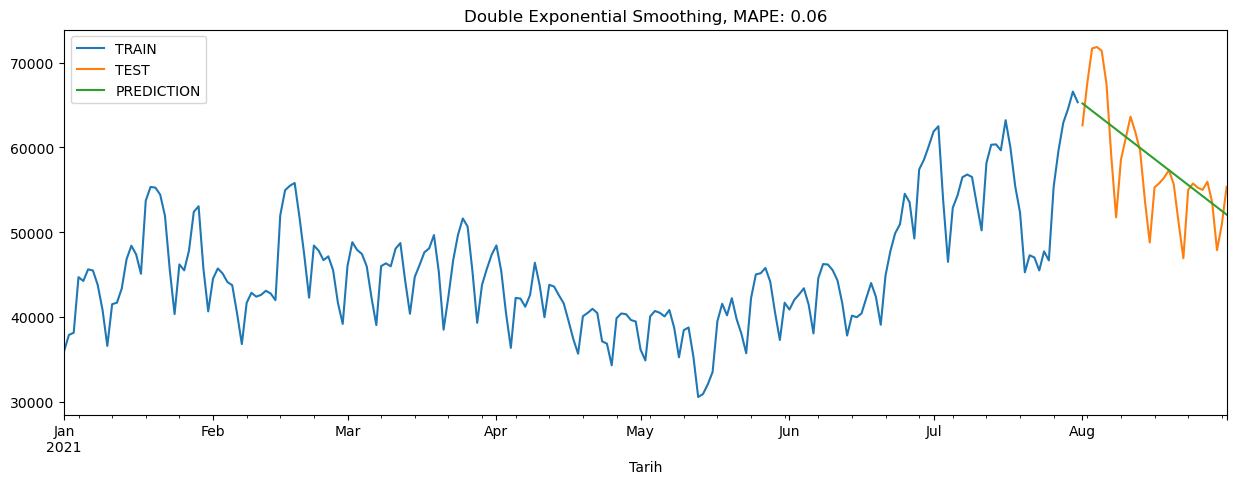

In [14]:
des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=0.91,
                                                         smoothing_trend=0.81)

y_pred = des_model.forecast(31)

plot_energy(train, val, y_pred, "Double Exponential Smoothing")

alpha: 0.01 beta: 0.01 mape: 0.1817
alpha: 0.01 beta: 0.11 mape: 0.1898
alpha: 0.01 beta: 0.21 mape: 0.2597
alpha: 0.01 beta: 0.31 mape: 0.3735
alpha: 0.01 beta: 0.41 mape: 0.1851
alpha: 0.01 beta: 0.51 mape: 0.0857
alpha: 0.01 beta: 0.61 mape: 0.1331
alpha: 0.01 beta: 0.71 mape: 0.0619
alpha: 0.01 beta: 0.81 mape: 0.1565
alpha: 0.01 beta: 0.91 mape: 0.0903
alpha: 0.11 beta: 0.01 mape: 0.1171
alpha: 0.11 beta: 0.11 mape: 0.1213
alpha: 0.11 beta: 0.21 mape: 0.1743
alpha: 0.11 beta: 0.31 mape: 0.4089
alpha: 0.11 beta: 0.41 mape: 0.6507
alpha: 0.11 beta: 0.51 mape: 0.8011
alpha: 0.11 beta: 0.61 mape: 0.9404
alpha: 0.11 beta: 0.71 mape: 1.1352
alpha: 0.11 beta: 0.81 mape: 1.4033
alpha: 0.11 beta: 0.91 mape: 1.7588
alpha: 0.21 beta: 0.01 mape: 0.1449
alpha: 0.21 beta: 0.11 mape: 0.2769
alpha: 0.21 beta: 0.21 mape: 0.554
alpha: 0.21 beta: 0.31 mape: 0.8663
alpha: 0.21 beta: 0.41 mape: 1.1901
alpha: 0.21 beta: 0.51 mape: 1.5108
alpha: 0.21 beta: 0.61 mape: 1.7472
alpha: 0.21 beta: 0.71 mape: 

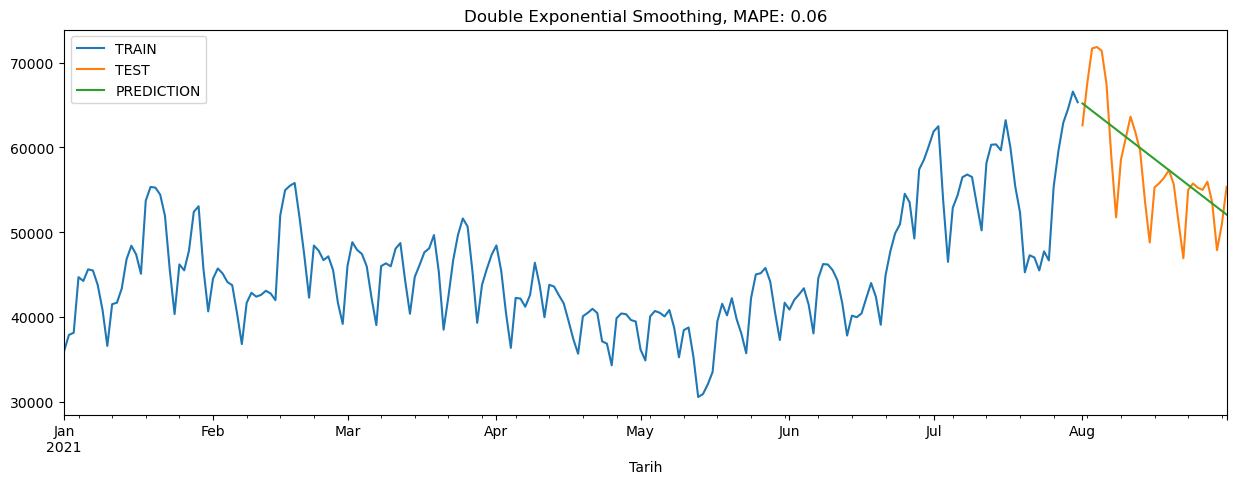

In [15]:
def des_optimizer(train, alphas, betas, step=31):
    best_alpha, best_beta, best_mape = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mape = mean_absolute_percentage_error(val, y_pred)
            if mape < best_mape:
                best_alpha, best_beta, best_mape = alpha, beta, mape
            print("alpha:", round(alpha, 2), "beta:", round(beta, 2),"mape:", round(mape, 4))
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mape:", round(best_mape, 4))
    return best_alpha, best_beta, best_mape

alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)

best_alpha, best_beta, best_mape = des_optimizer(train, alphas, betas)

############################
# Final DES Model
############################

final_des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=best_alpha, smoothing_slope=best_beta)

y_pred = final_des_model.forecast(31)

plot_energy(train, val, y_pred, "Double Exponential Smoothing")

# TES Model

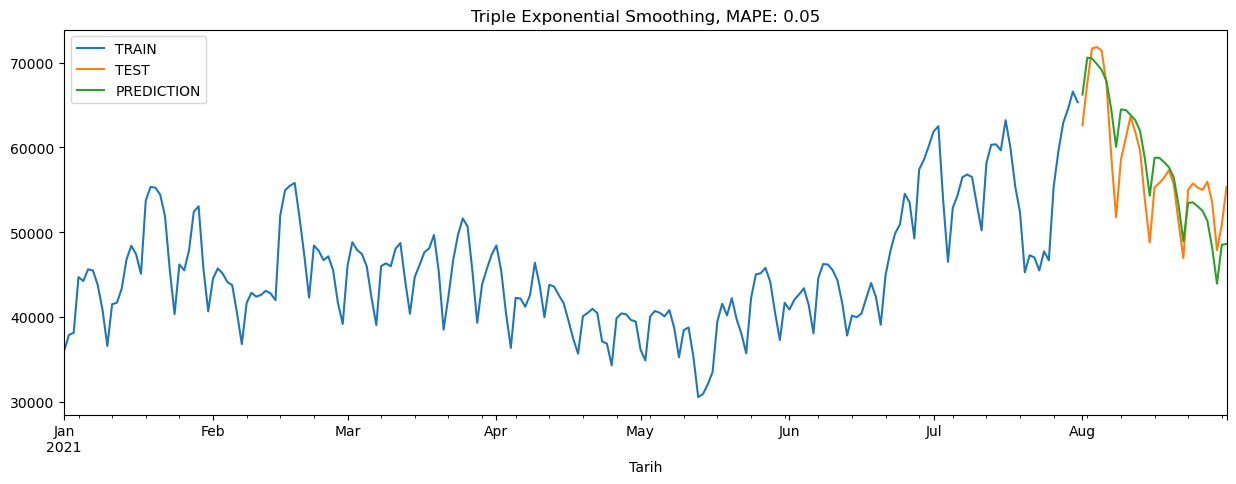

In [16]:
tes_model = ExponentialSmoothing(train, damped_trend=True,
                                 trend="add",
                                 seasonal="add",
                                 seasonal_periods=7).fit(smoothing_level=0.2,
                                                          smoothing_slope=1.6,
                                                          smoothing_seasonal=0.01)

y_pred = tes_model.forecast(31)
plot_energy(train, val, y_pred, "Triple Exponential Smoothing")

[0.0, 0.0, 0.0, 0.1206]
[0.0, 0.0, 0.2, 0.1114]
[0.0, 0.0, 0.4, 0.0721]
[0.0, 0.0, 0.6, 0.0709]
[0.0, 0.0, 0.8, 0.0787]
[0.0, 0.0, 1.0, 0.0964]
[0.0, 0.0, 1.2, 0.1332]
[0.0, 0.0, 1.4, 0.1879]
[0.0, 0.0, 1.6, 0.2728]
[0.0, 0.0, 1.8, 0.3783]
[0.0, 0.2, 0.0, 0.1206]
[0.0, 0.2, 0.2, 0.1114]
[0.0, 0.2, 0.4, 0.0721]
[0.0, 0.2, 0.6, 0.0709]
[0.0, 0.2, 0.8, 0.0787]
[0.0, 0.2, 1.0, 0.0964]
[0.0, 0.2, 1.2, 0.1332]
[0.0, 0.2, 1.4, 0.1879]
[0.0, 0.2, 1.6, 0.2728]
[0.0, 0.2, 1.8, 0.3783]
[0.0, 0.4, 0.0, 0.1206]
[0.0, 0.4, 0.2, 0.1114]
[0.0, 0.4, 0.4, 0.0721]
[0.0, 0.4, 0.6, 0.0709]
[0.0, 0.4, 0.8, 0.0787]
[0.0, 0.4, 1.0, 0.0964]
[0.0, 0.4, 1.2, 0.1332]
[0.0, 0.4, 1.4, 0.1879]
[0.0, 0.4, 1.6, 0.2728]
[0.0, 0.4, 1.8, 0.3783]
[0.0, 0.6, 0.0, 0.1206]
[0.0, 0.6, 0.2, 0.1114]
[0.0, 0.6, 0.4, 0.0721]
[0.0, 0.6, 0.6, 0.0709]
[0.0, 0.6, 0.8, 0.0787]
[0.0, 0.6, 1.0, 0.0964]
[0.0, 0.6, 1.2, 0.1332]
[0.0, 0.6, 1.4, 0.1879]
[0.0, 0.6, 1.6, 0.2728]
[0.0, 0.6, 1.8, 0.3783]
[0.0, 0.8, 0.0, 0.1206]
[0.0, 0.8, 0.2, 

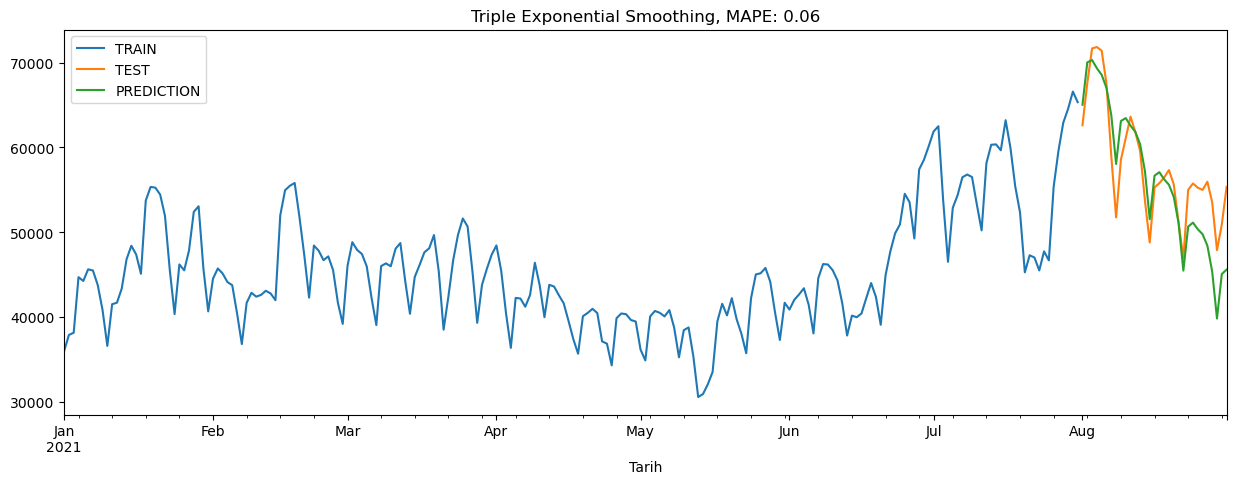

In [17]:
alphas = betas = gammas = np.arange(0, 2, 0.2)

abg = list(itertools.product(alphas, betas, gammas))


def tes_optimizer(train, abg, step=31):
    best_alpha, best_beta, best_gamma, best_mape = None, None, None,float("inf")
    for comb in abg:
        try:
            tes_model = ExponentialSmoothing(train, trend="add", damped_trend=True,
                                             seasonal="add", 
                                             seasonal_periods=7).fit(smoothing_level=comb[0], 
                                                                      smoothing_slope=comb[1], 
                                                                      smoothing_seasonal=comb[2])
            y_pred = tes_model.forecast(step)
            mape = mean_absolute_percentage_error(val, y_pred)
            if mape < best_mape:
                best_alpha, best_beta, best_gamma, best_mape = comb[0], comb[1], comb[2], mape
            print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mape, 4)])
        except ValueError:
            print("ValueError")
            continue
    print("best_alpha:", round(best_alpha, 2), "best_beta:", \
              round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
              "best_mape:", round(best_mape, 4))

    return best_alpha, best_beta, best_gamma, best_mape

best_alpha, best_beta, best_gamma, best_mape = tes_optimizer(train, abg)


############################
# Final TES Model
############################

final_tes_model = ExponentialSmoothing(train, trend="add", damped_trend=True,
                                       seasonal="add", seasonal_periods=7).fit(smoothing_level=best_alpha, 
                                                                                smoothing_trend=best_beta, 
                                                                                smoothing_seasonal=best_gamma)

y_pred = final_tes_model.forecast(31)

plot_energy(train, val, y_pred, "Triple Exponential Smoothing")

In [18]:
y_pred = pd.DataFrame(y_pred, columns =["Dağıtılan Enerji (MWh)"])
y_pred.index.name = "Tarih"

TES yöntemi ile olan Tahminler

In [19]:
y_pred

,Dağıtılan Enerji (MWh)
Tarih,
2021-08-01,65041.715
2021-08-02,70039.905
2021-08-03,70316.580
2021-08-04,69344.026
2021-08-05,68564.119
2021-08-06,67016.541
2021-08-07,63795.574
2021-08-08,58053.936
2021-08-09,63122.003


In [20]:
df_val.pivot_table(index=df_val.index.day, columns=df_val.index.time, values="Dağıtılan Enerji (MWh)")

,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,12:00:00,13:00:00,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
Tarih,,,,,,,,,,,,,,,,,,,,,,,,
1,2571.231,2422.248,2286.024,2173.951,2085.295,2035.667,1933.512,1964.352,2119.731,2330.280,2557.299,2734.587,2837.852,2948.862,3028.976,3025.833,3039.541,3024.563,3010.954,2939.810,2962.436,2960.258,2863.118,2762.371
2,2599.767,2417.311,2265.558,2168.613,2095.797,2050.471,1983.529,2115.059,2378.137,2331.901,2547.984,2937.612,3316.863,3442.557,3542.589,3538.235,3530.126,3436.133,3289.828,3195.033,3191.477,3197.715,3087.182,2941.117
3,2728.287,2548.589,2406.639,2301.360,2224.155,2178.900,2106.253,2218.004,2627.567,3004.987,3237.051,3408.608,3433.518,3572.222,3622.303,3633.105,3598.644,3529.023,3374.893,3268.184,3262.005,3254.209,3144.017,3004.567
4,2801.771,2625.833,2486.751,2377.803,2310.981,2264.558,2171.317,2265.307,2679.415,2995.541,3190.699,3376.463,3383.632,3524.357,3628.120,3609.105,3589.271,3501.846,3341.435,3256.649,3222.246,3201.823,3095.217,2952.524
5,2754.629,2577.483,2432.289,2312.640,2250.361,2198.620,2126.103,2240.062,2647.317,2983.650,3196.013,3368.363,3403.154,3501.032,3574.019,3592.697,3598.773,3513.598,3358.382,3252.254,3233.461,3224.071,3114.151,2955.672
6,2766.524,2575.934,2417.882,2315.341,2242.828,2182.637,2102.025,2178.772,2538.822,2833.211,3023.274,3204.934,3245.558,3312.217,3421.036,3392.276,3325.211,3200.384,3042.094,2937.258,2924.668,2886.458,2766.843,2644.534
7,2479.669,2338.169,2213.867,2120.091,2066.300,2031.921,1941.150,1992.309,2271.943,2516.920,2658.934,2761.331,2730.298,2784.404,2807.489,2767.604,2737.748,2685.098,2666.139,2592.655,2571.607,2515.442,2397.571,2283.574
8,2140.496,2013.149,1898.663,1823.231,1779.674,1743.902,1655.855,1669.906,1788.681,1954.696,2109.530,2220.618,2284.220,2372.219,2429.410,2460.632,2466.535,2468.217,2487.684,2452.057,2486.608,2456.429,2345.389,2242.089
9,2104.630,1967.391,1856.277,1785.493,1736.778,1719.054,1678.186,1807.298,2204.782,2520.056,2691.949,2809.501,2793.957,2917.422,3004.363,3020.592,3028.942,2946.337,2812.558,2743.354,2747.681,2685.596,2549.354,2416.290


In [21]:
table = pd.pivot_table(data = df_val, index=df_val.index.time, columns=df_val.index.day, values="Dağıtılan Enerji (MWh)")

sum_list = []
for col in range(1,table.shape[1]+1):
    sum_of_col = 0
    for row in range(0,table.shape[0]):
        sum_of_col += table[col][row]
    sum_list.append(sum_of_col)

for col in range(1,table.shape[1]+1):
    divider = sum_list[col-1]
    for row in range(0,table.shape[0]):
        table[col][row] = table[col][row]/divider

for col in range(1,table.shape[1]+1):
    sum_of_day = y_pred["Dağıtılan Enerji (MWh)"][col-1]
    for row in range(0,table.shape[0]):
        table[col][row] = table[col][row] * sum_of_day
table

Tarih,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
00:00:00,2670.722,2693.577,2676.128,2703.951,2644.894,2747.494,2684.302,2401.247,2269.058,2319.159,2330.845,2453.680,2302.391,2297.419,2094.114,2005.790,2124.978,2034.780,2050.327,2042.912,1988.665,1853.235,1722.295,1890.471,1856.964,1797.049,1745.070,1752.149,1680.088,1666.118,1622.969
01:00:00,2515.974,2504.537,2499.865,2534.156,2474.805,2558.215,2531.124,2258.386,2121.097,2173.165,2182.348,2305.222,2151.008,2159.298,1969.154,1868.581,1982.027,1892.344,1905.634,1895.027,1851.981,1733.961,1606.986,1750.893,1714.437,1668.076,1617.753,1625.191,1554.335,1544.008,1499.995
02:00:00,2374.479,2347.309,2360.629,2399.929,2335.395,2401.250,2396.565,2129.954,2001.302,2055.003,2064.245,2171.134,2039.504,2028.711,1859.844,1772.546,1872.251,1785.109,1787.647,1801.819,1746.320,1632.926,1525.474,1653.923,1614.943,1569.191,1529.912,1516.139,1443.707,1443.683,1419.847
03:00:00,2258.070,2246.865,2257.363,2294.785,2220.513,2299.414,2295.050,2045.333,1924.988,1976.239,1976.450,2080.027,1967.171,1947.293,1779.041,1700.698,1800.329,1721.254,1713.520,1740.697,1673.821,1564.745,1464.007,1592.095,1551.874,1516.209,1470.562,1450.449,1383.774,1372.250,1366.263
04:00:00,2165.983,2171.422,2181.634,2230.296,2160.715,2227.400,2236.821,1996.469,1872.467,1922.775,1918.114,2020.853,1911.171,1893.528,1748.462,1658.623,1752.340,1671.387,1662.026,1693.233,1646.117,1522.834,1440.059,1550.571,1519.311,1478.812,1435.836,1421.974,1338.294,1346.219,1336.628
05:00:00,2114.435,2124.460,2137.243,2185.494,2111.034,2167.623,2199.604,1956.339,1853.359,1902.383,1896.767,1996.361,1894.982,1863.305,1720.101,1661.767,1739.263,1670.677,1664.621,1677.159,1641.259,1499.540,1440.196,1536.454,1499.815,1469.188,1425.885,1409.851,1315.999,1332.631,1325.712
06:00:00,2008.327,2055.103,2065.986,2095.508,2041.407,2087.566,2101.342,1857.568,1809.297,1856.310,1839.309,1927.958,1835.125,1812.250,1650.541,1630.840,1697.703,1642.671,1639.494,1655.062,1590.858,1446.865,1432.696,1508.325,1478.763,1456.220,1409.557,1374.256,1264.637,1319.948,1329.878
07:00:00,2040.360,2191.380,2175.600,2186.217,2150.825,2163.785,2156.722,1873.330,1948.496,1966.578,1934.960,2029.473,1933.807,1871.994,1653.482,1753.896,1783.677,1734.262,1733.523,1749.061,1630.816,1437.698,1536.490,1593.570,1562.611,1526.902,1489.699,1406.024,1258.580,1364.800,1410.674
08:00:00,2201.751,2463.950,2577.333,2585.867,2541.857,2521.358,2459.434,2006.574,2377.035,2356.105,2329.529,2385.048,2316.899,2139.439,1786.361,2165.985,2164.858,2111.277,2096.208,2108.381,1892.338,1556.898,1908.902,1936.590,1920.182,1852.513,1813.700,1638.315,1371.007,1620.237,1736.459
09:00:00,2420.448,2416.045,2947.538,2890.956,2864.791,2813.723,2724.627,2192.812,2716.940,2657.300,2645.127,2686.491,2616.033,2408.999,1954.309,2464.933,2470.852,2406.604,2392.143,2386.643,2128.304,1716.798,2182.780,2200.324,2184.053,2111.019,2076.543,1873.132,1511.178,1851.433,2004.149


In [22]:
for col in range(1,table.shape[1]+1):
    sum_of_col = 0
    for row in range(0,table.shape[0]):
        sum_of_col += table[col][row]
        
counter=0
for col in range(1,table.shape[1]+1):
    for row in range(0,table.shape[0]):
        df_test["Dağıtılan Enerji (MWh)"][counter] = table[col][row]
        counter +=1
        
df_test.to_csv("submission.csv")

* Saatlik veriler ile yapılan TES ile alınan MAPE 0.07 Submission ise 10.12378

* Günlük veriler ile yapılan TES ile alınan MAPE 0.06 interpolate edilip son gün değerleri aynı alınınca Submission 19.23921

* Günlük veriler ile yapılan TES ile alınan MAPE 0.05 2021 Ağustos ayındaki dağılıma göre dağıtılınca Submission 11.85448

# ARIMA Model

In [23]:
arima_model = ARIMA(train, order=(1, 1, 1)).fit()

arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:     Dağıtılan Enerji (MWh)   No. Observations:                 1308
Model:                     ARIMA(1, 1, 1)   Log Likelihood              -12297.431
Date:                    Fri, 21 Apr 2023   AIC                          24600.862
Time:                            08:59:32   BIC                          24616.389
Sample:                        01-01-2018   HQIC                         24606.686
                             - 07-31-2021                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6854      0.028     24.134      0.000       0.630       0.741
ma.L1         -0.8893      0.021    -42.682      0.000      -0.930      -0.848
sigma2      9.204e+06   1.59e-10   5.79e+16      0.000     9.2e+06     9.2e+06
===================================================================================
Ljung-Box (L1) (Q):                  16.41   Jarque-Bera (JB):                 3.74
Prob(Q):                              0.00   Prob(JB):                         0.15
Heteroskedasticity (H):               1.17   Skew:                             0.11
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

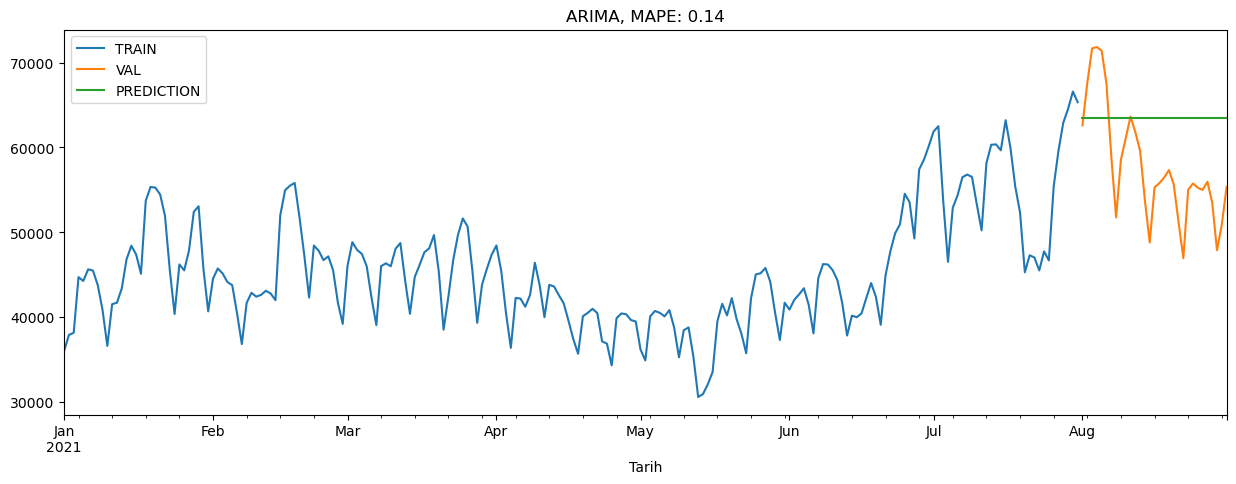

In [24]:
y_pred = arima_model.forecast(31)[0]
y_pred = pd.Series(y_pred, index=val.index)

def plot_energy(train, test, y_pred, title):
    mape = mean_absolute_percentage_error(test, y_pred)
    ax = train["2021.01.01":].plot(figsize=(15,5), legend=True, label="TRAIN", title=f"{title}, MAPE: {round(mape,2)}")
    test.plot(ax = ax, legend=True, label="VAL")
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show(block=True)
    
plot_energy(train, val, y_pred, "ARIMA")

Best ARIMANone AIC=inf


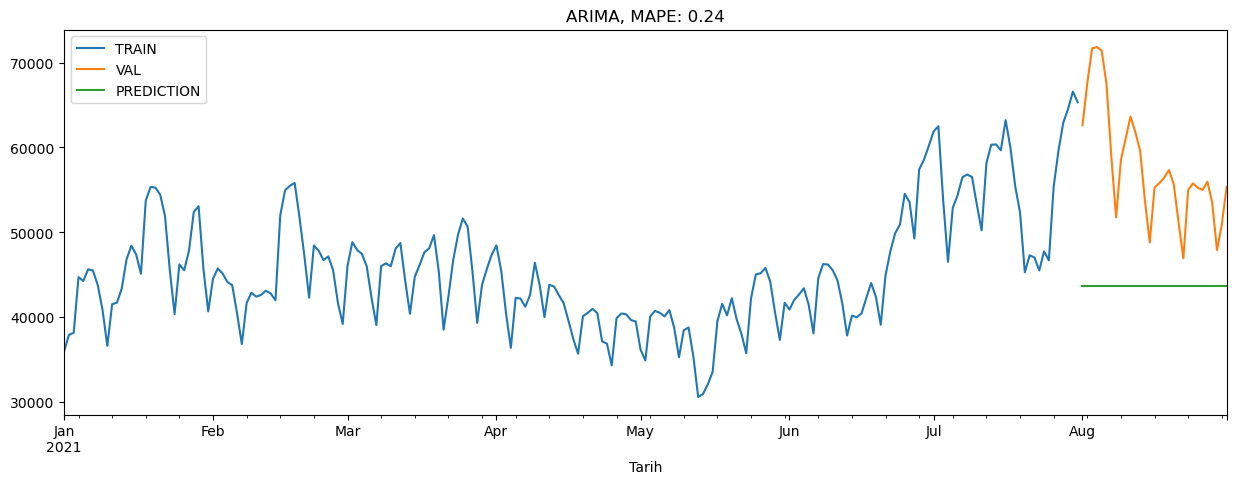

In [25]:
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))


def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arima_model_result = ARIMA(train, order).fit()
            aic = arima_model_result.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
            print('ARIMA%s AIC=%.2f' % (order, aic))
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' % (best_params, best_aic))
    return best_params

best_params_aic = arima_optimizer_aic(train, pdq)

############################
# Final Model
############################

arima_model = ARIMA(train, best_params_aic).fit()
y_pred = arima_model.forecast(31)[0]

y_pred = pd.Series(y_pred, index=val.index)

plot_energy(train, val, y_pred, "ARIMA")

# SARIMA Model

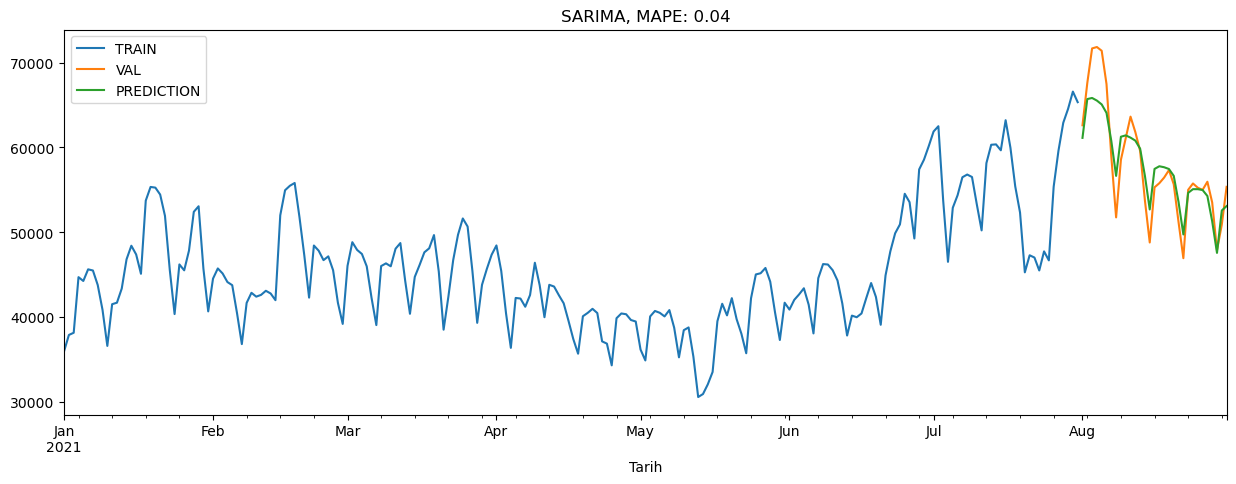

In [26]:
model = SARIMAX(train, order=(1, 0, 0), seasonal_order=(1, 1, 1, 7))

sarima_model = model.fit(disp=0)

y_pred_val = sarima_model.get_forecast(steps=31)

y_pred = y_pred_val.predicted_mean

y_pred = pd.Series(y_pred, index=val.index)

plot_energy(train, val, y_pred, "SARIMA")

SARIMA(0, 0, 0)x(0, 0, 0, 7)7 - AIC:31690.59551377923
SARIMA(0, 0, 0)x(0, 0, 1, 7)7 - AIC:30786.678216001077
SARIMA(0, 0, 0)x(0, 1, 0, 7)7 - AIC:25502.31020391121
SARIMA(0, 0, 0)x(0, 1, 1, 7)7 - AIC:25417.456582151513
SARIMA(0, 0, 0)x(1, 0, 0, 7)7 - AIC:25673.400374132994
SARIMA(0, 0, 0)x(1, 0, 1, 7)7 - AIC:25528.407576591046
SARIMA(0, 0, 0)x(1, 1, 0, 7)7 - AIC:25414.833989789404
SARIMA(0, 0, 0)x(1, 1, 1, 7)7 - AIC:25415.805733663896
SARIMA(0, 0, 1)x(0, 0, 0, 7)7 - AIC:29979.88380881759
SARIMA(0, 0, 1)x(0, 0, 1, 7)7 - AIC:28593.600974842935
SARIMA(0, 0, 1)x(0, 1, 0, 7)7 - AIC:24431.505279303317
SARIMA(0, 0, 1)x(0, 1, 1, 7)7 - AIC:24275.44619934849
SARIMA(0, 0, 1)x(1, 0, 0, 7)7 - AIC:27910.47848710045
SARIMA(0, 0, 1)x(1, 0, 1, 7)7 - AIC:24367.364456230833
SARIMA(0, 0, 1)x(1, 1, 0, 7)7 - AIC:24277.606070413698
SARIMA(0, 0, 1)x(1, 1, 1, 7)7 - AIC:24274.28605977883
SARIMA(0, 1, 0)x(0, 0, 0, 7)7 - AIC:24688.136051698028
SARIMA(0, 1, 0)x(0, 0, 1, 7)7 - AIC:24306.15475415084
SARIMA(0, 1, 0)x(

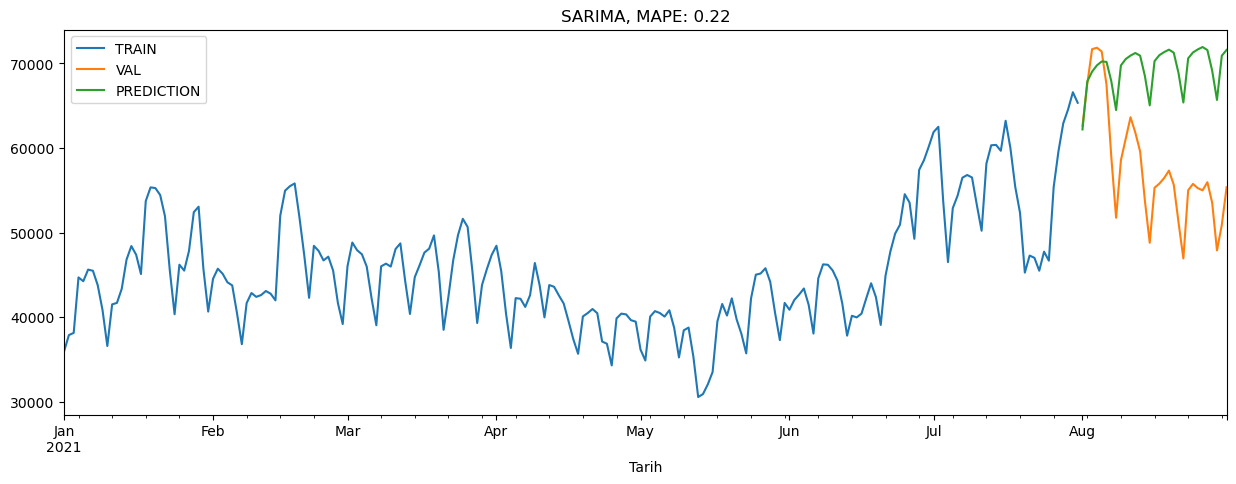

In [27]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]


def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
                print('SARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, aic))
            except:
                continue
    print('Best SARIMA{}x{}7 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order

best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)


############################
# Final Model
############################

model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)

y_pred_val = sarima_final_model.get_forecast(steps=31)

y_pred = y_pred_val.predicted_mean
y_pred = pd.Series(y_pred, index=val.index)

plot_energy(train, val, y_pred, "SARIMA")

SARIMA(0, 0, 0)x(0, 0, 0, 7)7 - MAPE:1.0
SARIMA(0, 0, 0)x(0, 0, 1, 7)7 - MAPE:0.8677
SARIMA(0, 0, 0)x(0, 1, 0, 7)7 - MAPE:0.1076
SARIMA(0, 0, 0)x(0, 1, 1, 7)7 - MAPE:0.0864
SARIMA(0, 0, 0)x(1, 0, 0, 7)7 - MAPE:0.1036
SARIMA(0, 0, 0)x(1, 0, 1, 7)7 - MAPE:0.0779
SARIMA(0, 0, 0)x(1, 1, 0, 7)7 - MAPE:0.0879
SARIMA(0, 0, 0)x(1, 1, 1, 7)7 - MAPE:0.0871
SARIMA(0, 0, 1)x(0, 0, 0, 7)7 - MAPE:0.9836
SARIMA(0, 0, 1)x(0, 0, 1, 7)7 - MAPE:0.8514
SARIMA(0, 0, 1)x(0, 1, 0, 7)7 - MAPE:0.1089
SARIMA(0, 0, 1)x(0, 1, 1, 7)7 - MAPE:0.0845
SARIMA(0, 0, 1)x(1, 0, 0, 7)7 - MAPE:0.202
SARIMA(0, 0, 1)x(1, 0, 1, 7)7 - MAPE:0.0773
SARIMA(0, 0, 1)x(1, 1, 0, 7)7 - MAPE:0.0875
SARIMA(0, 0, 1)x(1, 1, 1, 7)7 - MAPE:0.0853
SARIMA(0, 1, 0)x(0, 0, 0, 7)7 - MAPE:0.1648
SARIMA(0, 1, 0)x(0, 0, 1, 7)7 - MAPE:0.3253
SARIMA(0, 1, 0)x(0, 1, 0, 7)7 - MAPE:0.9148
SARIMA(0, 1, 0)x(0, 1, 1, 7)7 - MAPE:0.1834
SARIMA(0, 1, 0)x(1, 0, 0, 7)7 - MAPE:0.494
SARIMA(0, 1, 0)x(1, 0, 1, 7)7 - MAPE:0.1834
SARIMA(0, 1, 0)x(1, 1, 0, 7)7 - MAPE:

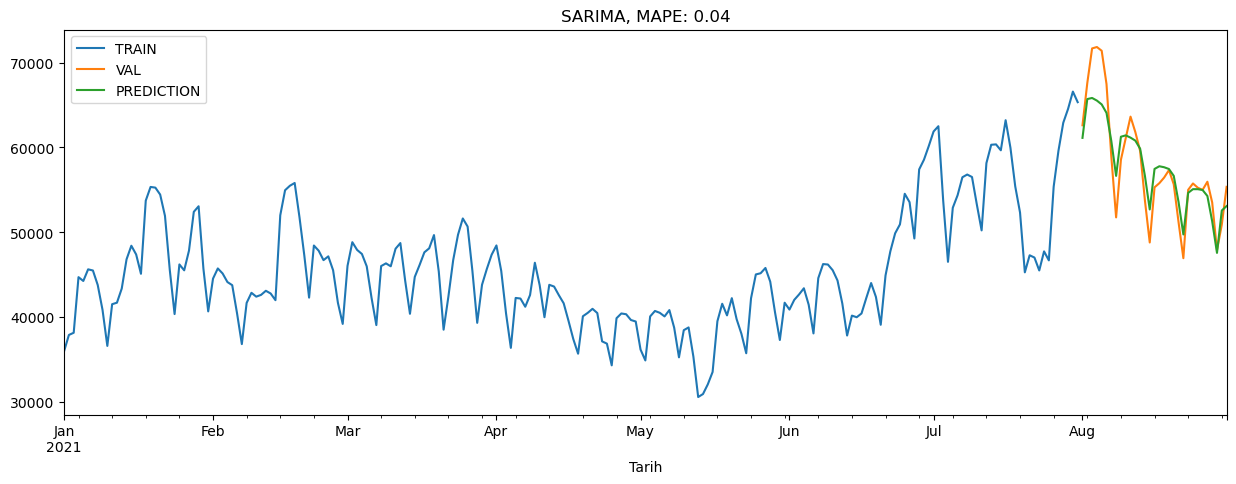

In [28]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]


def sarima_optimizer_mape(train, pdq, seasonal_pdq):
    best_mape, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(train, order=param,seasonal_order=param_seasonal)
                sarima_model = model.fit(disp=0)
                y_pred_val = sarima_model.get_forecast(steps=31)
                y_pred = y_pred_val.predicted_mean
                mape = round(mean_absolute_percentage_error(val, y_pred), 4)
                if mape < best_mape:
                    best_mape, best_order, best_seasonal_order = round(mape, 4), param, param_seasonal
                print('SARIMA{}x{}7 - MAPE:{}'.format(param, param_seasonal, mape))
            except:
                continue
    print('Best SARIMA{}x{}7 - MAPE:{}'.format(best_order, best_seasonal_order, round(best_mape, 4)))
    return best_order, best_seasonal_order

best_order, best_seasonal_order = sarima_optimizer_mape(train, pdq, seasonal_pdq)

model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)

y_pred_val = sarima_final_model.get_forecast(steps=31)
y_pred = y_pred_val.predicted_mean
y_pred = pd.Series(y_pred, index=val.index)

plot_energy(train, val, y_pred, "SARIMA")

In [30]:
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)

y_pred = sarima_final_model.get_forecast(steps=31)
y_pred = y_pred.predicted_mean

In [31]:
y_pred

2021-08-01   61132.766
2021-08-02   65712.352
2021-08-03   65841.516
2021-08-04   65532.336
2021-08-05   65077.804
2021-08-06   64079.770
2021-08-07   60771.068
2021-08-08   56648.357
2021-08-09   61268.199
2021-08-10   61427.609
2021-08-11   61162.037
2021-08-12   60808.200
2021-08-13   59861.768
2021-08-14   56639.064
2021-08-15   52687.782
2021-08-16   57469.730
2021-08-17   57783.988
2021-08-18   57667.303
2021-08-19   57458.559
2021-08-20   56649.109
2021-08-21   53559.135
2021-08-22   49738.776
2021-08-23   54645.987
2021-08-24   55080.160
2021-08-25   55078.313
2021-08-26   54979.626
2021-08-27   54275.465
2021-08-28   51286.367
2021-08-29   47562.754
2021-08-30   52562.589
2021-08-31   53085.442
Freq: D, Name: predicted_mean, dtype: float64

In [32]:
y_pred = pd.DataFrame(y_pred)
y_pred.index.name = "Tarih"
y_pred.rename(columns={"predicted_mean":"Dağıtılan Enerji (MWh)"}, inplace=True)

In [33]:
y_pred

,Dağıtılan Enerji (MWh)
Tarih,
2021-08-01,61132.766
2021-08-02,65712.352
2021-08-03,65841.516
2021-08-04,65532.336
2021-08-05,65077.804
2021-08-06,64079.770
2021-08-07,60771.068
2021-08-08,56648.357
2021-08-09,61268.199


In [34]:
table = pd.pivot_table(data = df_val, index=df_val.index.time, columns=df_val.index.day, values="Dağıtılan Enerji (MWh)")

sum_list = []
for col in range(1,table.shape[1]+1):
    sum_of_col = 0
    for row in range(0,table.shape[0]):
        sum_of_col += table[col][row]
    sum_list.append(sum_of_col)

for col in range(1,table.shape[1]+1):
    divider = sum_list[col-1]
    for row in range(0,table.shape[0]):
        table[col][row] = table[col][row]/divider

for col in range(1,table.shape[1]+1):
    sum_of_day = y_pred["Dağıtılan Enerji (MWh)"][col-1]
    for row in range(0,table.shape[0]):
        table[col][row] = table[col][row] * sum_of_day
table

Tarih,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
00:00:00,2510.214,2527.149,2505.815,2555.321,2510.408,2627.095,2557.041,2343.108,2202.419,2244.606,2278.622,2412.285,2282.962,2274.225,2140.713,2033.950,2151.021,2086.266,2119.045,2136.116,2084.988,2027.207,1857.655,2036.340,2031.193,1985.398,1956.738,1980.658,2007.170,1943.421,1889.842
01:00:00,2364.766,2349.790,2340.770,2394.859,2348.967,2446.110,2411.125,2203.707,2058.803,2103.306,2133.452,2266.331,2132.856,2137.498,2012.973,1894.814,2006.317,1940.225,1969.502,1981.484,1941.684,1896.736,1733.283,1885.992,1875.294,1842.908,1813.978,1837.143,1856.936,1800.986,1746.648
02:00:00,2231.775,2202.276,2210.395,2268.010,2216.646,2296.024,2282.946,2078.384,1942.527,1988.943,2017.995,2134.505,2022.293,2008.229,1901.230,1797.431,1895.196,1830.277,1847.560,1884.024,1830.905,1786.216,1645.365,1781.540,1766.465,1733.658,1715.482,1713.868,1724.770,1683.964,1653.320
03:00:00,2122.362,2108.038,2113.700,2168.646,2107.605,2198.650,2186.243,1995.812,1868.454,1912.711,1932.168,2044.936,1950.570,1927.633,1818.629,1724.575,1822.393,1764.807,1770.949,1820.113,1754.894,1711.635,1579.067,1714.941,1697.478,1675.123,1648.934,1639.612,1653.170,1600.643,1590.925
04:00:00,2035.809,2037.257,2042.791,2107.702,2050.848,2129.792,2130.774,1948.131,1817.475,1860.965,1875.138,1986.759,1895.043,1874.411,1787.370,1681.909,1773.816,1713.678,1717.729,1770.483,1725.848,1665.790,1553.236,1670.214,1661.860,1633.807,1609.995,1607.423,1598.835,1570.278,1556.417
05:00:00,1987.359,1993.196,2001.226,2065.362,2003.693,2072.635,2095.322,1908.973,1798.928,1841.229,1854.270,1962.681,1878.991,1844.493,1758.378,1685.097,1760.578,1712.950,1720.411,1753.676,1720.754,1640.309,1553.384,1655.007,1640.535,1623.174,1598.837,1593.719,1572.200,1554.429,1543.706
06:00:00,1887.629,1928.124,1934.503,1980.323,1937.606,1996.085,2001.719,1812.593,1756.161,1796.637,1798.099,1895.432,1819.638,1793.953,1687.269,1653.736,1718.509,1684.235,1694.442,1730.571,1667.913,1582.689,1545.295,1624.708,1617.508,1608.847,1580.529,1553.482,1510.839,1539.635,1548.557
07:00:00,1917.736,2055.981,2037.142,2066.046,2041.461,2068.964,2054.474,1827.974,1891.272,1903.360,1891.607,1995.234,1917.488,1853.095,1690.277,1778.520,1805.536,1778.144,1791.623,1828.858,1709.806,1572.661,1657.246,1716.530,1709.222,1686.937,1670.392,1589.393,1503.603,1591.952,1642.639
08:00:00,2069.428,2311.710,2413.307,2443.728,2412.610,2410.868,2342.833,1957.992,2307.225,2280.365,2277.336,2344.810,2297.347,2117.840,1826.112,2196.394,2191.389,2164.698,2166.463,2204.571,1983.995,1703.051,2058.928,2086.018,2100.343,2046.676,2033.692,1851.978,1637.918,1889.903,2021.994
09:00:00,2274.981,2266.765,2759.951,2732.047,2719.124,2690.421,2595.454,2139.721,2637.147,2571.878,2585.863,2641.168,2593.957,2384.678,1997.797,2499.539,2501.133,2467.498,2472.316,2495.529,2231.391,1877.963,2354.330,2370.102,2388.972,2332.275,2328.417,2117.419,1805.377,2159.578,2333.702


In [35]:
for col in range(1,table.shape[1]+1):
    sum_of_col = 0
    for row in range(0,table.shape[0]):
        sum_of_col += table[col][row]
        
counter=0
for col in range(1,table.shape[1]+1):
    for row in range(0,table.shape[0]):
        df_test["Dağıtılan Enerji (MWh)"][counter] = table[col][row]
        counter +=1
        
df_test.to_csv("submission.csv")

* Günlük veriler ile yapılan SARIMA ile alınan MAPE 0.04 2021 Ağustos ayındaki dağılıma göre dağıtılınca Submission 9.32323